In [2]:
# настройка окружения

import numpy as np             
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd          
import seaborn as sns 
import sklearn
from sklearn import ensemble

### Описание задачи

Датасет заказов индийкого агрегатора такси Sigma Cabs https://www.kaggle.com/arashnic/taxi-pricing-with-mobility-analytics

Описание полей:  
Trip_ID: ID поездки  
Trip_Distance: Расстояние заказанной клиентом поездки  
TypeofCab: Запрашиваемая категория такси   
CustomerSinceMonths: На протяжении какого количества месяцев клиент использует данный сервис  
LifeStyleIndex: Индекс, характеризующий образ жизни клиентов на основе анализа их поведения  
ConfidenceLifeStyle_Index: Категория, характеризующая степень доверия к показателю выше  
Destination_Type: Одна из 14 категорий маршрута   
Customer_Rating: Средний рейтинг клиента на момент формирования датасета  
CancellationLast1Month: Число отмененных клиентом поездок за последний месяц   
Var1, Var2 and Var3: Переменные, описания которых скрыты создателями датасета   
Gender: Пол клиента  
SurgePricingType: Стратегия ценообразования   

Задача: построить модель, выбирающую по представленным данным о будущей поездке одну из 3 стратегий ценообразования (параметр SurgePricingType)

### Загрузка данных

In [3]:
prefix='.'
try:
    from google.colab import drive
    drive.mount('/mnt/data')
    prefix='/mnt/data/MyDrive'
except ImportError:
  pass
data = pd.read_csv(f'{prefix}/data/sigma_cabs.csv')

Mounted at /mnt/data


In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Как мы видим, признак Trip_ID бесполезен для анализа и его можно удалить из таблицы:

In [5]:
data['Trip_ID'].describe()

count          131662
unique         131662
top       T0005853913
freq                1
Name: Trip_ID, dtype: object

Зададим категориальным признакам соответсвующий тип данных

In [6]:
data['Type_of_Cab'] = data['Type_of_Cab'].astype('category')
data['Confidence_Life_Style_Index'] = data['Confidence_Life_Style_Index'].astype('category')
data['Destination_Type'] = data['Destination_Type'].astype('category')
data['Gender'] = data['Gender'].astype('category')
data['Surge_Pricing_Type'] = data['Surge_Pricing_Type'].astype('category')

In [7]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Trip_ID                      131662 non-null  object  
 1   Trip_Distance                131662 non-null  float64 
 2   Type_of_Cab                  111452 non-null  category
 3   Customer_Since_Months        125742 non-null  float64 
 4   Life_Style_Index             111469 non-null  float64 
 5   Confidence_Life_Style_Index  111469 non-null  category
 6   Destination_Type             131662 non-null  category
 7   Customer_Rating              131662 non-null  float64 
 8   Cancellation_Last_1Month     131662 non-null  int64   
 9   Var1                         60632 non-null   float64 
 10  Var2                         131662 non-null  int64   
 11  Var3                         131662 non-null  int64   
 12  Gender                       131662 non-null

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [8]:
data.tail()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
131657,T0005908509,11.72,D,1.0,2.74229,A,A,3.28500,0,61.0,47,76,Male,3
131658,T0005908510,74.81,C,7.0,2.81059,C,A,0.44500,0,NaN,63,88,Male,2
131659,T0005908512,40.17,C,10.0,2.99565,B,A,3.33625,0,NaN,48,75,Female,2
131660,T0005908513,46.88,B,4.0,3.04744,A,B,4.15750,1,47.0,54,79,Male,2
131661,T0005908514,31.96,A,7.0,2.93773,A,E,2.63875,1,102.0,57,85,Male,1


### Визуализация данных

Получим сводную информацию о характеристиках количественных и категориальных признаков:

In [9]:
data.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,60632.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,64.202698,51.202800,75.099019
std,25.522882,3.626887,0.225796,0.980675,1.037559,21.820447,4.986142,11.578278
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,46.000000,48.000000,67.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,80.000000,54.000000,82.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000


In [10]:
data.describe(include=['category'])

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender,Surge_Pricing_Type
count,111452,111469,131662,131662,131662
unique,5,3,14,2,3
top,B,B,A,Male,2
freq,31136,40355,77597,93900,56728


Определим распределение значений целевой переменной

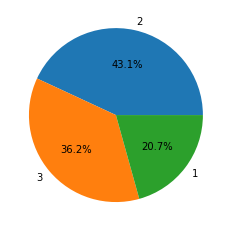

In [11]:
plt.pie(data['Surge_Pricing_Type'].value_counts(), labels=data['Surge_Pricing_Type'].unique(), autopct='%1.1f%%')
pass

Вывод: выборка является относительно сбалансированной. Вычислим матрицу корреляции для количественных признаков:

In [12]:
corr_mat = data.corr()
corr_mat

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3
Trip_Distance,1.000000,0.116812,0.509482,-0.054654,-0.007686,-0.045468,0.200456,0.231706
Customer_Since_Months,0.116812,1.000000,0.135114,-0.050349,-0.006325,-0.009856,0.042637,0.113403
Life_Style_Index,0.509482,0.135114,1.000000,0.205824,0.074023,-0.091307,0.234754,0.329312
Customer_Rating,-0.054654,-0.050349,0.205824,1.000000,0.003595,-0.010968,-0.302968,-0.227531
Cancellation_Last_1Month,-0.007686,-0.006325,0.074023,0.003595,1.000000,0.010953,0.095830,0.128686
Var1,-0.045468,-0.009856,-0.091307,-0.010968,0.010953,1.000000,-0.046755,-0.061993
Var2,0.200456,0.042637,0.234754,-0.302968,0.095830,-0.046755,1.000000,0.683437
Var3,0.231706,0.113403,0.329312,-0.227531,0.128686,-0.061993,0.683437,1.000000


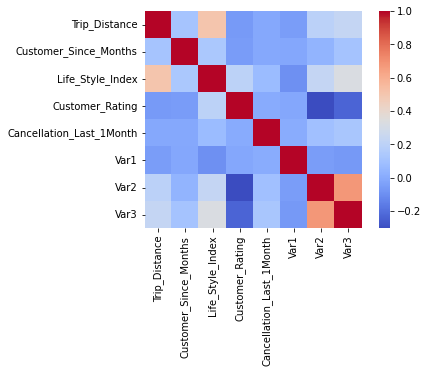

In [13]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')

Можно заметить, что существует значительная корреляция между признаками Life_Style_Index и Trip_Distance (длина поездок влияет на рассчет индекса образа жизни клиентов), Var2 и Var3.  
Также существует отрицательная корреляция между Customer_Rating и столбцами Var2 и Var3.

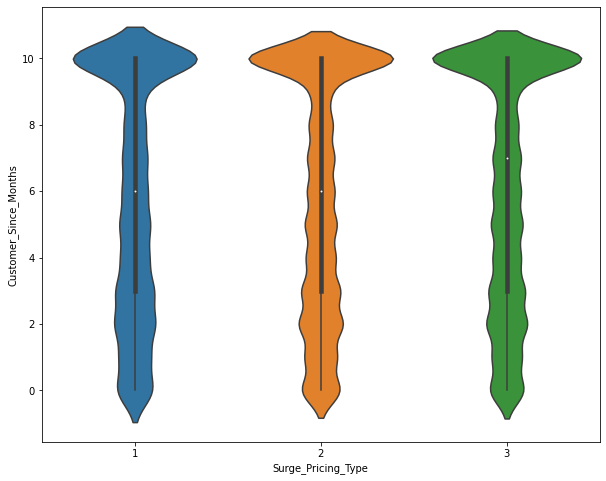

In [14]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)

plt.figure(figsize = (10, 8))
sns.violinplot(x = "Surge_Pricing_Type", y = "Customer_Since_Months", data = data)
pass

Вывод: выбор стратегии ценообразования не зависит от срока использования сервиса

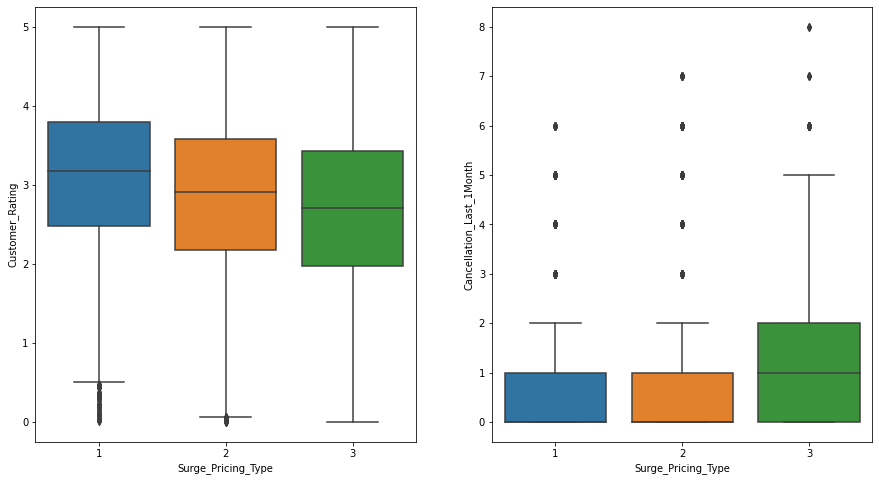

In [15]:
f, ax = plt.subplots(1, 2, figsize = (15,8))
sns.boxplot(x = "Surge_Pricing_Type", y = "Customer_Rating", data = data, ax=ax[0])
sns.boxplot(x = "Surge_Pricing_Type", y = "Cancellation_Last_1Month", data = data, ax=ax[1])
pass

Выводы: 
1. Номер стратегии ценообразования обратно пропорционален рейтингу клиента. 
2. Чем ниже рейтинг и больше отмен заказов, тем с большей вероятностью будет назначена третья стратегия.
3. Стратегии 1 и 2 перестают назначаться после определенного для каждой из них порога отмен заказов

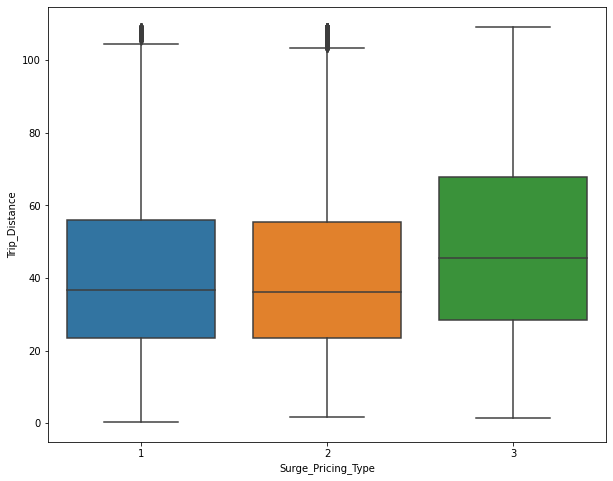

In [16]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = "Surge_Pricing_Type", y = "Trip_Distance", data = data)
pass

Вывод: стратегия 3 чаще используется при дальних поездках

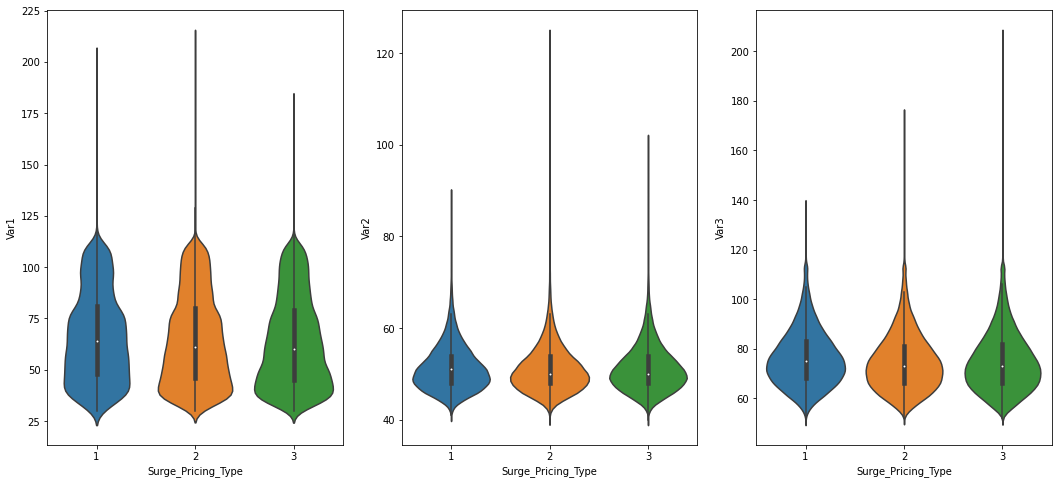

In [17]:
f, ax = plt.subplots(1, 3, figsize = (18,8))
sns.violinplot(x = "Surge_Pricing_Type", y = "Var1", data = data, ax = ax[0])
sns.violinplot(x = "Surge_Pricing_Type", y = "Var2", data = data, ax = ax[1])
sns.violinplot(x = "Surge_Pricing_Type", y = "Var3", data = data, ax = ax[2])
pass

Вывод: Скрытые переменные напрямую не влияют на выбор стратегии ценообразования

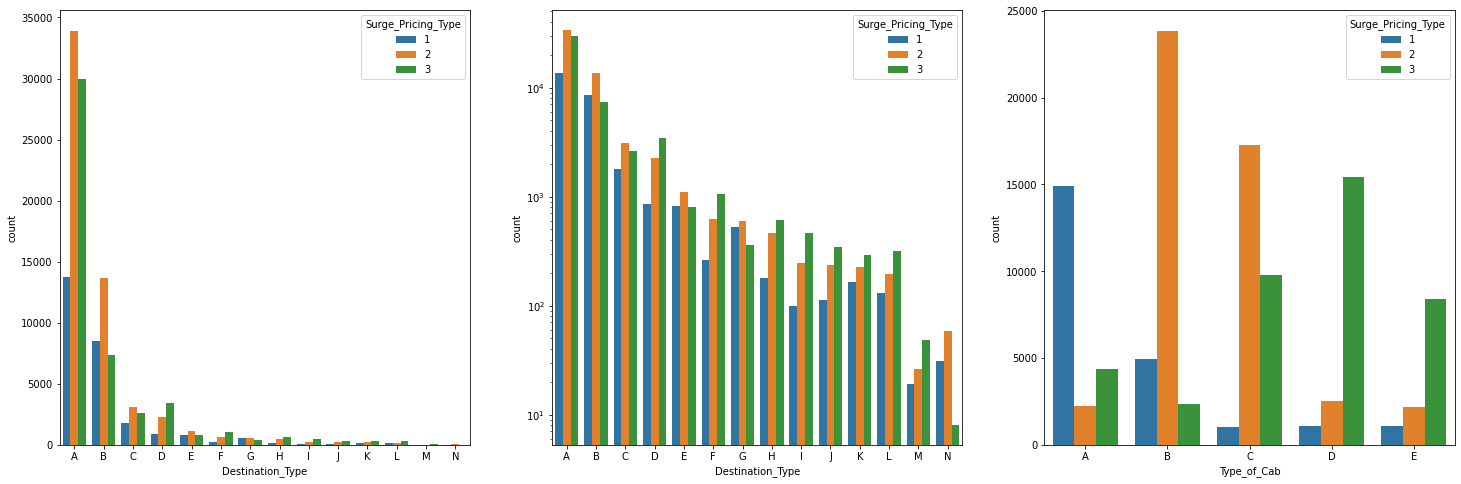

In [18]:
f, ax = plt.subplots(1, 3, figsize = (25,8))
sns.countplot(x = 'Destination_Type', hue = 'Surge_Pricing_Type', data = data,ax = ax[0])
g = sns.countplot(x = 'Destination_Type', hue = 'Surge_Pricing_Type', data = data,ax = ax[1])
g.set_yscale("log")
sns.countplot(x = 'Type_of_Cab', hue = 'Surge_Pricing_Type', data = data, ax = ax[2])
plt.show()

Вывод: 
1. У многих классов автомобиля заметно доминирует определенная стратегия
2. Существует зависимость между стратегией ценообразования и категорией пункта назначения 

Построим все возможные диаграммы рассеивания для каждой пары переменных:

No handles with labels found to put in legend.


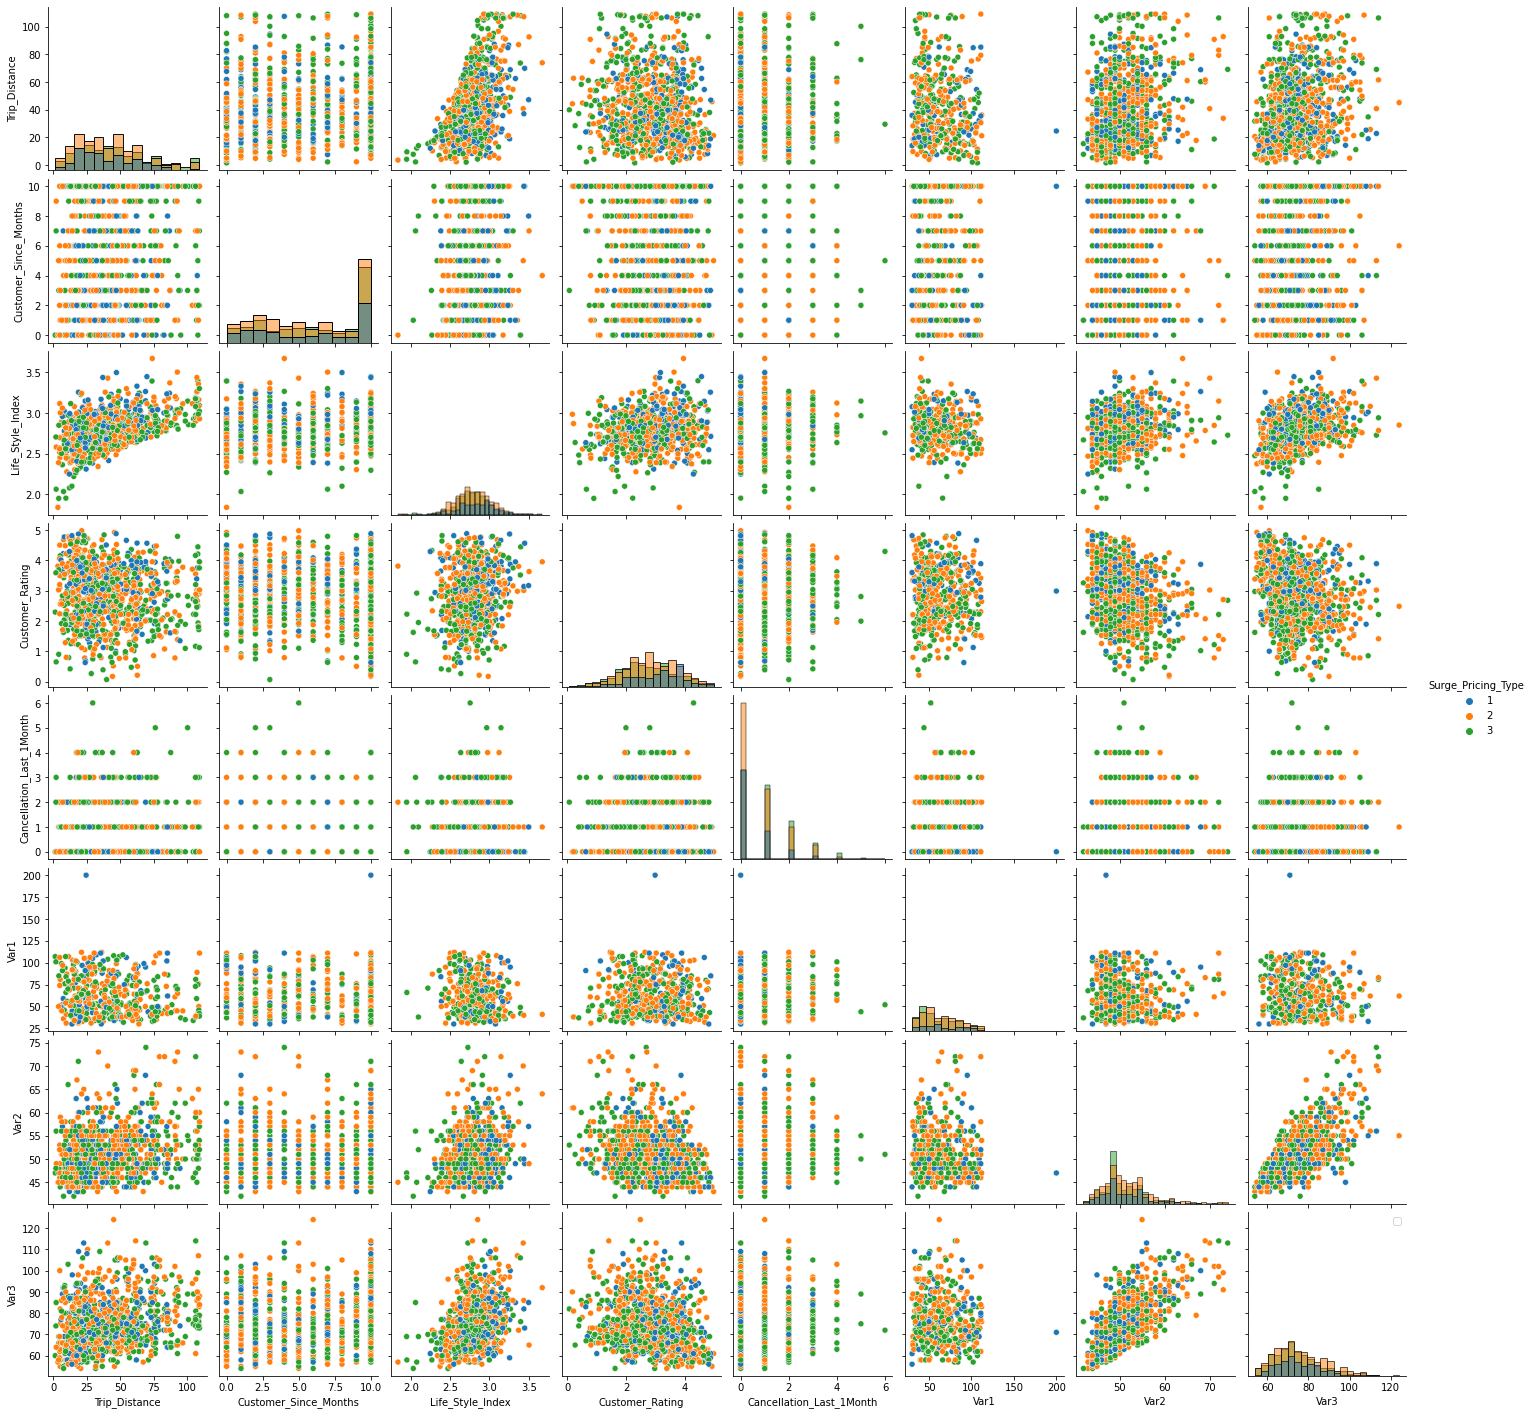

In [19]:
sns.pairplot(data.iloc[random_subset], hue='Surge_Pricing_Type', diag_kind='hist')
plt.legend()
pass

Можно сделать предположения о видах взаимосвязи между признаками: Life_Style_Index и Trip_Distance - параболическая; Var2 и Var3 - линейная.  
Также на графиках для Var1 заметно наличие выбросов

### Обработка пропущенных значений

Определим количество пропусков для каждого признака:

In [20]:
data.isna().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

Количество строк с пропущенными значениями достаточно большое относительно размера датасета, поэтому заполним пропущенные значения медианой (для количественных признаков) и модой (для категориальных признаков)

In [21]:
data.fillna(data.median(axis = 0, numeric_only=True), axis=0 , inplace=True)
data['Type_of_Cab'].fillna(data['Type_of_Cab'].mode().iloc[0], inplace=True)
data['Confidence_Life_Style_Index'].fillna(data['Confidence_Life_Style_Index'].mode().iloc[0], inplace=True)
data.isna().sum()

Trip_ID                        0
Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

In [22]:
data.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3
count,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.015912,2.801448,2.849458,0.782838,62.474883,51.202800,75.099019
std,25.522882,3.544411,0.207765,0.980675,1.037559,14.893324,4.986142,11.578278
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000
25%,24.580000,3.000000,2.687952,2.152500,0.000000,61.000000,48.000000,67.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000
75%,60.730000,10.000000,2.912815,3.582500,1.000000,61.000000,54.000000,82.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000


In [23]:
data.describe(include=['category'])

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender,Surge_Pricing_Type
count,131662,131662,131662,131662,131662
unique,5,3,14,2,3
top,B,B,A,Male,2
freq,51346,60548,77597,93900,56728


### Обработка категориальных признаков

Закодируем значения бинарного категориального признака числами 0 и 1:

In [24]:
data['Gender'] = data['Gender'].cat.codes

Закодируем небинарные категориальные признаки с помощью one-hot encoding:

In [25]:
data = pd.concat((data, pd.get_dummies(data['Type_of_Cab'], prefix='Type_of_Cab')), axis=1)
data = data.drop(['Type_of_Cab'], axis=1)

data = pd.concat((data, pd.get_dummies(data['Confidence_Life_Style_Index'], prefix='Confidence_Life_Style_Index')), axis=1)
data = data.drop(['Confidence_Life_Style_Index'], axis=1)

data = pd.concat((data, pd.get_dummies(data['Destination_Type'], prefix='Destination_Type')), axis=1)
data = data.drop(['Destination_Type'], axis=1)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   Trip_ID                        131662 non-null  object  
 1   Trip_Distance                  131662 non-null  float64 
 2   Customer_Since_Months          131662 non-null  float64 
 3   Life_Style_Index               131662 non-null  float64 
 4   Customer_Rating                131662 non-null  float64 
 5   Cancellation_Last_1Month       131662 non-null  int64   
 6   Var1                           131662 non-null  float64 
 7   Var2                           131662 non-null  int64   
 8   Var3                           131662 non-null  int64   
 9   Gender                         131662 non-null  int8    
 10  Surge_Pricing_Type             131662 non-null  category
 11  Type_of_Cab_A                  131662 non-null  uint8   
 12  Type_of_Cab_B   

### Удаление выбросов и нормализация

In [27]:
data['Var1'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     31.0
0.010     33.0
0.050     38.0
0.100     44.0
0.500     61.0
0.900     83.0
0.950     97.0
0.990    109.0
0.995    110.0
Name: Var1, dtype: float64

In [28]:
rows_to_drop = data[
    (data['Var1'] < data['Var1'].quantile(0.005)) | (data['Var1'] > data['Var1'].quantile(0.995))].index
data = data.drop(rows_to_drop)
data.shape

(130788, 33)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130788 entries, 0 to 131661
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   Trip_ID                        130788 non-null  object  
 1   Trip_Distance                  130788 non-null  float64 
 2   Customer_Since_Months          130788 non-null  float64 
 3   Life_Style_Index               130788 non-null  float64 
 4   Customer_Rating                130788 non-null  float64 
 5   Cancellation_Last_1Month       130788 non-null  int64   
 6   Var1                           130788 non-null  float64 
 7   Var2                           130788 non-null  int64   
 8   Var3                           130788 non-null  int64   
 9   Gender                         130788 non-null  int8    
 10  Surge_Pricing_Type             130788 non-null  category
 11  Type_of_Cab_A                  130788 non-null  uint8   
 12  Type_of_Cab_B   

Выполним стандартизацию всех признаков

In [30]:
X = data.drop(['Surge_Pricing_Type', 'Trip_ID'], axis=1)

X = (X - X.mean(axis = 0))/X.std(axis = 0)
X.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Type_of_Cab_A,Type_of_Cab_B,Type_of_Cab_C,Type_of_Cab_D,Type_of_Cab_E,Confidence_Life_Style_Index_A,Confidence_Life_Style_Index_B,Confidence_Life_Style_Index_C,Destination_Type_A,Destination_Type_B,Destination_Type_C,Destination_Type_D,Destination_Type_E,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N
count,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05,1.307880e+05
mean,2.363320e-15,2.114473e-16,7.584037e-13,1.440349e-14,-9.784738e-17,-2.593352e-15,1.287634e-15,3.040558e-16,5.291309e-16,-2.012907e-15,-2.423400e-15,8.923990e-16,-3.474260e-15,-8.942665e-16,7.523521e-16,7.631175e-16,-5.144030e-16,2.012537e-15,8.098920e-17,-1.516751e-15,2.391593e-15,-1.212930e-15,3.206582e-15,1.057103e-14,3.273890e-15,3.715168e-15,-1.125976e-15,-8.433667e-16,4.651633e-16,1.425282e-15,1.458259e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.720178e+00,-1.698107e+00,-5.801179e+00,-2.904766e+00,-7.545226e-01,-2.168429e+00,-2.246737e+00,-1.995196e+00,-1.576643e+00,-4.427112e-01,-7.996857e-01,-5.210450e-01,-4.104238e-01,-3.113634e-01,-6.027045e-01,-9.231752e-01,-6.134389e-01,-1.198302e+00,-5.383614e-01,-2.450866e-01,-2.294813e-01,-1.452139e-01,-1.224796e-01,-1.069834e-01,-9.811331e-02,-7.869606e-02,-7.266686e-02,-7.191876e-02,-7.001427e-02,-2.653146e-02,-2.653146e-02
25%,-7.687872e-01,-8.515327e-01,-5.462293e-01,-7.106409e-01,-7.545226e-01,-9.032581e-02,-6.426021e-01,-6.996551e-01,-1.576643e+00,-4.427112e-01,-7.996857e-01,-5.210450e-01,-4.104238e-01,-3.113634e-01,-6.027045e-01,-9.231752e-01,-6.134389e-01,-1.198302e+00,-5.383614e-01,-2.450866e-01,-2.294813e-01,-1.452139e-01,-1.224796e-01,-1.069834e-01,-9.811331e-02,-7.869606e-02,-7.266686e-02,-7.191876e-02,-7.001427e-02,-2.653146e-02,-2.653146e-02
50%,-2.351660e-01,-4.958223e-03,-1.676436e-02,4.665729e-02,-7.545226e-01,-9.032581e-02,-2.415683e-01,-9.506923e-02,6.342543e-01,-4.427112e-01,-7.996857e-01,-5.210450e-01,-4.104238e-01,-3.113634e-01,-6.027045e-01,-9.231752e-01,-6.134389e-01,8.345077e-01,-5.383614e-01,-2.450866e-01,-2.294813e-01,-1.452139e-01,-1.224796e-01,-1.069834e-01,-9.811331e-02,-7.869606e-02,-7.266686e-02,-7.191876e-02,-7.001427e-02,-2.653146e-02,-2.653146e-02
75%,6.469884e-01,1.123808e+00,5.358182e-01,7.478593e-01,2.090890e-01,-9.032581e-02,5.604992e-01,5.958861e-01,6.342543e-01,-4.427112e-01,1.250482e+00,-5.210450e-01,-4.104238e-01,-3.113634e-01,1.659175e+00,1.083210e+00,1.630142e+00,8.345077e-01,-5.383614e-01,-2.450866e-01,-2.294813e-01,-1.452139e-01,-1.224796e-01,-1.069834e-01,-9.811331e-02,-7.869606e-02,-7.266686e-02,-7.191876e-02,-7.001427e-02,-2.653146e-02,-2.653146e-02
max,2.546441e+00,1.123808e+00,9.981468e+00,2.193610e+00,6.954370e+00,3.303910e+00,1.459668e+01,1.130569e+01,6.342543e-01,2.258792e+00,1.250482e+00,1.919205e+00,2.436487e+00,3.211657e+00,1.659175e+00,1.083210e+00,1.630142e+00,8.345077e-01,1.857474e+00,4.080159e+00,4.357620e+00,6.886342e+00,8.164565e+00,9.347171e+00,1.019222e+01,1.270702e+01,1.376133e+01,1.390447e+01,1.428269e+01,3.769082e+01,3.769082e+01


### Разбиение на обучающую и тестовую выборки

Разобьем данные на обучающую и тестовую выборки

In [31]:
y = data['Surge_Pricing_Type']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test


(98091, 32697)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98091 entries, 131046 to 122769
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Trip_Distance                  98091 non-null  float64
 1   Customer_Since_Months          98091 non-null  float64
 2   Life_Style_Index               98091 non-null  float64
 3   Customer_Rating                98091 non-null  float64
 4   Cancellation_Last_1Month       98091 non-null  float64
 5   Var1                           98091 non-null  float64
 6   Var2                           98091 non-null  float64
 7   Var3                           98091 non-null  float64
 8   Gender                         98091 non-null  float64
 9   Type_of_Cab_A                  98091 non-null  float64
 10  Type_of_Cab_B                  98091 non-null  float64
 11  Type_of_Cab_C                  98091 non-null  float64
 12  Type_of_Cab_D                  98091 non

### Запуск классификатора по методу k-ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
print(f'train error: {err_train}')

y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
print(f'test error: {err_test}')

train error: 0.3108440121927598
test error: 0.32165030430926383


Подберем оптимальное значение параметра n_neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

nnb = [1, 5, 10, 12, 15, 25]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=5, verbose=3)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=1, score=0.570, total= 1.9min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.564, total= 1.9min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.565, total= 1.9min
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.568, total= 1.9min
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.566, total= 1.9min
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.634, total= 1.9min
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.638, total= 1.9min
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.632, total= 2.0min
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.635, total= 2.0min
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 59.4min finished


0.32558536844182107 25


### Сравнение с другими алгоритмами классификации

Попробуем запустить некоторые другие алгоритмы классификации.  
#### Random Forest:

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)

err_train  = np.mean(y_train  != rf.predict(X_train))
print(f'train error: {err_train}')
err_test  = np.mean(y_test  != rf.predict(X_test))
print(f'test error: {err_test}')

train error: 0.0001325299976552385
test error: 0.3187448389760528


#### AdaBoost

In [ ]:
ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
print(f'train error: {err_train}')
err_test = np.mean(y_test != ada.predict(X_test))
print(f'test error: {err_test}')

train error: 0.31743992822990896
test error: 0.3177049882252194


#### Gradient Boosting

In [ ]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
print(f'train error: {err_train}')
err_test = np.mean(y_test != gbt.predict(X_test))
print(f'test error: {err_test}')

train error: 0.3095391014466159
test error: 0.3089580083799737


### Выводы 1:   
#### Выводы о датасете:   
1. Выборка является сбалансированной (соотношение 21% / 43% / 36%)
2. Существует заметная корреляция между признаками Life_Style_Index и Trip_Distance (обоснование: ндекса образа жизни клиента рассчитывается на основе расстояния поездок), а также Var2 и Var3.
3. Существует отрицательная корреляция между признаком Customer_Rating и признаками Var2 и Var3
4. Выбор стратегии ценообразования для клиента не зависит от срока использования сервиса
5. Номер стратегии ценообразования зависит от рейтинга клиента (чем ниже рейтинг и больше отмен заказов, тем с большей вероятностью будет назначена стратегия 3)
6. Стратегии 1 и 2 перестают назначаться после определенного для каждой из них порога отмен заказов
7. Стратегия 3 чаще используется при дальних поездках
8. Скрытые признаки (Var1, Var2, Var3) напрямую не влияют на выбор стратегии ценообразования
9. Признак Var1 содержит выбросы
10. Сущестует зависимость выбора стратегии от запрошенного класса автомобиля (у многих из них заметно превышена доля определенной стратегии)
11. На выбор стратегии ценообразования также влияет категория пункта назначения
12. Можно сделать предположение, что признаки Life_Style_Index и Trip_Distance имеют зависимость по параболе; Var2 и Var3 имеют линейную зависимость.

#### Выводы об алгоритмах обучения применительно к данному датасету:    
1. Алгоритм kNN при оптимальном среди протестированных значении n_neighbors равном 30 достигает точности 69% на тренировочной выборке и 68% на тестовой выборке
1. Применение стандартизации признаков уменьшает ошибку на тестовой выборке примерно на 10% при использовании алгоритма kNN
1. Алгоритм случайный лес показал точность 68% на тестовой выборке (с параметром n_estimators=50)
1. Алгоритм AdaBoost показал точность 68,3% на тестовой выборке (с параметром n_estimators=1000)
1. Среди протестированных алгоритмов наибольшую точность показал градиентный бустинг (с параметром n_estimators=100): 70% на теренировочной и тестовой выборках
1. Среди протестированных алгоритмов самым быстрым алгоритмом оказался случайный лес, самым медленным - kNN.
1. Ошибка на тестовой выборке, полученная участниками Kaggle, находится в пределах 30-33%: https://www.kaggle.com/arashnic/taxi-pricing-with-mobility-analytics/code

### Обучение классификатора на основе нейронной сети

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                     solver = 'lbfgs', 
                     activation = 'logistic',
                     random_state = 42,
                     alpha=0.01,
                     verbose=True)
mlp_model.fit(X_train1, y_train1)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.01, random_state=42,
              solver='lbfgs', verbose=True)

Попробуем заменить алгоритм сходимости на adam, рекомендованный в документации scikit-learn для относительно больших датасетов

In [ ]:
model = MLPClassifier(hidden_layer_sizes = (50,),
                     solver = 'adam', 
                     activation = 'logistic',
                     random_state = 42,
                     alpha=0.01,
                     verbose=True)
model.fit(X_train, y_train)

Iteration 1, loss = 0.83398876
Iteration 2, loss = 0.75184552
Iteration 3, loss = 0.75107512
Iteration 4, loss = 0.75030815
Iteration 5, loss = 0.74953872
Iteration 6, loss = 0.74893337
Iteration 7, loss = 0.74796695
Iteration 8, loss = 0.74706015
Iteration 9, loss = 0.74643899
Iteration 10, loss = 0.74569212
Iteration 11, loss = 0.74527914
Iteration 12, loss = 0.74477743
Iteration 13, loss = 0.74399210
Iteration 14, loss = 0.74376085
Iteration 15, loss = 0.74346296
Iteration 16, loss = 0.74323069
Iteration 17, loss = 0.74277203
Iteration 18, loss = 0.74235814
Iteration 19, loss = 0.74191638
Iteration 20, loss = 0.74141844
Iteration 21, loss = 0.74122928
Iteration 22, loss = 0.74083218
Iteration 23, loss = 0.74020341
Iteration 24, loss = 0.73970240
Iteration 25, loss = 0.73883546
Iteration 26, loss = 0.73815987
Iteration 27, loss = 0.73748178
Iteration 28, loss = 0.73678478
Iteration 29, loss = 0.73629548
Iteration 30, loss = 0.73547003
Iteration 31, loss = 0.73533748
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50,),
              random_state=42, verbose=True)

In [ ]:
err_train = np.mean(y_train != model.predict(X_train))
print(f'train error: {err_train}')
err_test = np.mean(y_test != model.predict(X_test))
print(f'test error: {err_test}')

train error: 0.30754095686658306
test error: 0.3092944306817139


Выполним подбор оптимального значения параметра alpha для 1 скрытого слоя из 50 нейронов:

In [37]:
alpha_arr = np.logspace(-3, 2, 21)
test_err_arr = []
train_err_arr = []
train_acc_arr = []
test_acc_arr = []

for i, alpha in enumerate(alpha_arr):
    mlp_model = MLPClassifier(hidden_layer_sizes = (50,),
                              solver = 'adam', 
                              activation = 'logistic',
                              random_state = 42,
                              max_iter=500,
                              alpha=alpha)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err = np.mean(y_train != y_train_pred)
    test_err = np.mean(y_test != y_test_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f'iter {i} alpha={alpha}: train acc {train_acc} err {train_err}, test acc {test_acc} err {test_err}')
    
    train_err_arr.append(train_err)
    test_err_arr.append(test_err)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
    
    

iter 0 alpha=0.001: train acc 0.6958334607660234 err 0.30416653923397663, test acc 0.6902773954797076 err 0.3097226045202924
iter 1 alpha=0.0017782794100389228: train acc 0.6956091792315299 err 0.30439082076847007, test acc 0.6895739670306145 err 0.3104260329693856
iter 2 alpha=0.0031622776601683794: train acc 0.6964859161390954 err 0.30351408386090467, test acc 0.6912254946937028 err 0.3087745053062972
iter 3 alpha=0.005623413251903491: train acc 0.6930095523544464 err 0.3069904476455536, test acc 0.6903691470165458 err 0.30963085298345416
iter 4 alpha=0.01: train acc 0.6924590431334169 err 0.30754095686658306, test acc 0.6907055693182861 err 0.3092944306817139
iter 5 alpha=0.01778279410038923: train acc 0.6921226208316767 err 0.3078773791683233, test acc 0.6907361531638988 err 0.3092638468361012
iter 6 alpha=0.03162277660168379: train acc 0.6905526500902224 err 0.3094473499097777, test acc 0.6897574701042909 err 0.3102425298957091
iter 7 alpha=0.05623413251903491: train acc 0.6889520

Построим графики зависимости ошибки и точности на обучающей и тестовой выборках от параметра alpha:

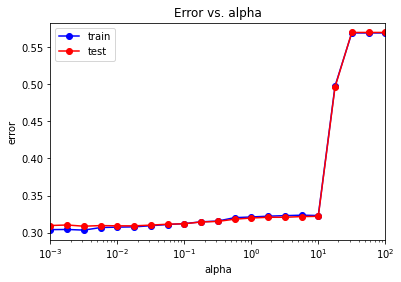

In [38]:
plt.semilogx(alpha_arr, train_err_arr, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err_arr, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

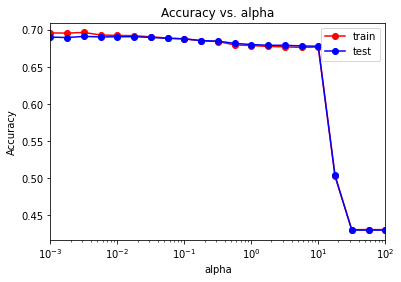

In [40]:
plt.semilogx(alpha_arr, train_acc_arr, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc_arr, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Из приведенных графиков видно, что при больших значениях alpha наблюдается недообучение

In [42]:
min_train_err = np.min(train_err_arr)
min_test_err = np.min(test_err_arr)
print(min_train_err, min_test_err)

0.30351408386090467 0.3087745053062972


Найдем оптимальное значение параметра alpha и обучим на нем сеть:

In [48]:
alpha_opt = alpha_arr[test_err_arr == min_test_err][0]
alpha_opt

0.0031622776601683794

In [ ]:
model = MLPClassifier(hidden_layer_sizes = (50,30),
                     solver = 'adam', 
                     activation = 'logistic',
                     random_state = 42,
                     alpha=alpha_opt,
                     verbose=True)
model.fit(X_train, y_train)

Iteration 1, loss = 0.83932599
Iteration 2, loss = 0.75144949
Iteration 3, loss = 0.74941252
Iteration 4, loss = 0.74893504
Iteration 5, loss = 0.74775261
Iteration 6, loss = 0.74742533
Iteration 7, loss = 0.74681155
Iteration 8, loss = 0.74638407
Iteration 9, loss = 0.74593617
Iteration 10, loss = 0.74567558
Iteration 11, loss = 0.74486010
Iteration 12, loss = 0.74445738
Iteration 13, loss = 0.74379165
Iteration 14, loss = 0.74336532
Iteration 15, loss = 0.74253637
Iteration 16, loss = 0.74199603
Iteration 17, loss = 0.74133863
Iteration 18, loss = 0.74081154
Iteration 19, loss = 0.74037362
Iteration 20, loss = 0.73968297
Iteration 21, loss = 0.73902276
Iteration 22, loss = 0.73825494
Iteration 23, loss = 0.73768022
Iteration 24, loss = 0.73664113
Iteration 25, loss = 0.73631014
Iteration 26, loss = 0.73572920
Iteration 27, loss = 0.73520848
Iteration 28, loss = 0.73461307
Iteration 29, loss = 0.73440944
Iteration 30, loss = 0.73348102
Iteration 31, loss = 0.73345328
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.0031622776601683794,
              hidden_layer_sizes=(50, 30), random_state=42, verbose=True)

In [54]:
err_train = np.mean(y_train != model.predict(X_train))
print(f'train error: {err_train}')
err_test = np.mean(y_test != model.predict(X_test))
print(f'test error: {err_test}')

train error: 0.30476802153102733
test error: 0.3088356729975227


Используя полученное оптимальное значение alpha, найдем оптимальное количество нейронов в сети с одним скрытым слоем:

In [59]:
first_layer_arr = [5, 10, 20, 25, 30, 40, 50, 70, 100, 120]
test_err_arr = []
train_err_arr = []
train_acc_arr = []
test_acc_arr = []

for i, n1 in enumerate(first_layer_arr):
    mlp_model = MLPClassifier(hidden_layer_sizes = (n1,),
                              solver = 'adam', 
                              activation = 'logistic',
                              random_state = 42,
                              max_iter=500,
                              alpha=alpha_opt)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err = np.mean(y_train != y_train_pred)
    test_err = np.mean(y_test != y_test_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f'iter {i} n1={n1}: train acc {train_acc} err {train_err}, test acc {test_acc} err {test_err}')
    
    train_err_arr.append(train_err)
    test_err_arr.append(test_err)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)

iter 0 n1=5: train acc 0.6856592347921827 err 0.31434076520781723, test acc 0.6843135455852218 err 0.3156864544147781
iter 1 n1=10: train acc 0.688534116279781 err 0.311465883720219, test acc 0.6879224393675261 err 0.31207756063247394
iter 2 n1=20: train acc 0.6916128900714642 err 0.30838710992853574, test acc 0.6903385631709331 err 0.3096614368290669
iter 3 n1=25: train acc 0.6934988938842503 err 0.30650110611574966, test acc 0.6909502400831881 err 0.30904975991681194
iter 4 n1=30: train acc 0.6936110346514971 err 0.3063889653485029, test acc 0.6904914823989968 err 0.3095085176010032
iter 5 n1=40: train acc 0.6942329061789563 err 0.3057670938210437, test acc 0.6911643270024773 err 0.3088356729975227
iter 6 n1=50: train acc 0.6964859161390954 err 0.30351408386090467, test acc 0.6912254946937028 err 0.3087745053062972
iter 7 n1=70: train acc 0.6981374438021837 err 0.3018625561978163, test acc 0.691561916995443 err 0.308438083004557
iter 8 n1=100: train acc 0.6980558868805496 err 0.30194

In [61]:
min_train_err = np.min(train_err_arr)
min_test_err = np.min(test_err_arr)
print(min_train_err, min_test_err)

0.30093484621422967 0.30822399608526774


In [66]:
n1_opt =  np.array(first_layer_arr)[test_err_arr == min_test_err][0]
n1_opt

100

Наилучший результат показала сеть со 100 нейронами в слое. Построим график заввисимости ошибки от количества нейронов:

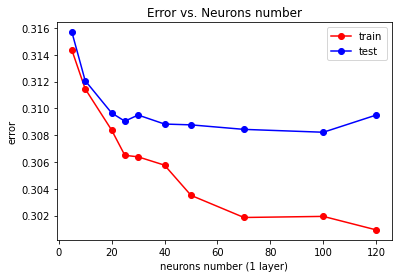

In [60]:
plt.plot(first_layer_arr, train_err_arr, 'r-o', label = 'train')
plt.plot(first_layer_arr, test_err_arr, 'b-o', label = 'test')
plt.title('Error vs. Neurons number')
plt.xlabel('neurons number (1 layer)')
plt.ylabel('error')
plt.legend()
pass

Из приведенного графика видно, что при малом количестве нейронов наблюдается недообучение, при слишком большом происходит переобучение - ошибка на тренировочной выборке уменьшается, но на тестовой выборке начинает расти.  
Попробуем обучить сеть с двумя скрытыми слоями, при этом определив оптимальное количество нейронов в этих слоях:

In [ ]:
first_layer_arr = [5, 10, 20, 30, 40, 50, 70, 100, 110]
second_layer_arr = [5, 10, 20, 30, 40, 50, 70, 100, 110]
test_err_arr = []
train_err_arr = []
train_acc_arr = []
test_acc_arr = []

for n1 in first_layer_arr:
  for n2 in second_layer_arr:
      mlp_model = MLPClassifier(hidden_layer_sizes = (n1,n2),
                                solver = 'adam', 
                                activation = 'logistic',
                                random_state = 42,
                                max_iter=500,
                                alpha=alpha_opt)
      mlp_model.fit(X_train, y_train)

      y_train_pred = mlp_model.predict(X_train)
      y_test_pred = mlp_model.predict(X_test)
      
      train_err = np.mean(y_train != y_train_pred)
      test_err = np.mean(y_test != y_test_pred)
      train_acc = accuracy_score(y_train, y_train_pred)
      test_acc = accuracy_score(y_test, y_test_pred)
      
      print(f'n1={n1}, n2={n2}: train acc {train_acc} err {train_err}, test acc {test_acc} err {test_err}')
      
      train_err_arr.append(train_err)
      test_err_arr.append(test_err)
      train_acc_arr.append(train_acc)
      test_acc_arr.append(test_acc)

n1=5, n2=5:  train acc 0.6874738762985391 err 0.3125261237014609, test acc 0.6876777686026241 err 0.3123222313973759
n1=5, n2=10: train acc 0.6850475578799278 err 0.3149524421200722, test acc 0.685750986329021 err 0.314249013670979
n1=5, n2=20: train acc 0.6847009409629834 err 0.31529905903701666, test acc 0.6844358809676728 err 0.3155641190323271
n1=5, n2=30: train acc 0.6869845347687351 err 0.31301546523126483, test acc 0.6870660916903691 err 0.31293390830963086
n1=5, n2=40: train acc 0.6857204024834083 err 0.31427959751659174, test acc 0.6861485763219868 err 0.3138514236780133
n1=5, n2=50: train acc 0.6852106717231958 err 0.31478932827680417, test acc 0.68562865094657 err 0.31437134905343
n1=5, n2=70: train acc 0.6857815701746337 err 0.31421842982536624, test acc 0.6861485763219868 err 0.3138514236780133
n1=5, n2=100: train acc 0.6844664648132857 err 0.3155335351867144, test acc 0.6856898186377955 err 0.3143101813622045
n1=5, n2=110: train acc 0.6853126178752383 err 0.31468738212476

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


n1=110, n2=100: train acc 0.7143876604377568 err 0.28561233956224324, test acc 0.6814998317888491 err 0.31850016821115085
n1=110, n2=110: train acc 0.7118084227910817 err 0.28819157720891825, test acc 0.6818056702449766 err 0.3181943297550234


In [38]:
min_train_err = np.min(train_err_arr)
min_test_err = np.min(test_err_arr)
print(min_train_err, min_test_err)

0.28561233956224324 0.30718414533443433


Определим при каком количестве нейронов в 1 и 2 слоях ошибка на тестовой выборке минимальна:

In [52]:
n1_opt = first_layer_arr[int(test_err_arr.index(min_test_err)/len(first_layer_arr))]
n2_opt = second_layer_arr[int(test_err_arr.index(min_test_err)%len(second_layer_arr))]
print(n1,n2)

40 50


### Выводы:
1. При использовании классификатора на основе неглубокой нейронной сети удалось добиться значения ошибки 0.307 на тестовой выборке
2. Данный результат был достигнут при использовании параметра alpha~=0.00316 и нейронной сети с двумя скрытыми слоями по 40 и 50 нейронов
3. При использовании нейронной сети с одним скрытым слоем наилучший реезультат был достигнут при использовании 100 нейронов (ошибка на тестовой выборке 0.308)